# Imports & Session Utils

In [1]:
import numpy as np
import typing as tp
from tqdm.notebook import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
from IPython.display import display

from sys import path
path.append("src")
from src.Enums import Markets, Derivatives
from src.Pricing import price
from src.StateHolder import StateHolder
from src.SessionManager import disk_memoize, Session

In [2]:
session = Session(
    new = True, 
    name = None
)
session

Session(5)

In [3]:
# session.clear()

# Generating data

In [4]:
CNT = 50_000

In [5]:
@disk_memoize(session_id=session.id)
def generate_data(CNT):
    init_market = StateHolder(
        np.array([
                100.,  # asset0,
                0.2,  # sigma
                0.05  # discount rate
            ]),
        Markets.BlackScholes
    )
    
    init_option_put = StateHolder(
        np.array([
            100.,  # strike
            1.  # maturity
        ]),
        Derivatives.OptionPut
    )
    init_option_call = StateHolder(
        np.array([
            100.,  # strike
            1.  # maturity
        ]),
        Derivatives.OptionCall
    )
    init_forward = StateHolder(
        np.array([
            100.,  # strike
            1.  # maturity
        ]),
        Derivatives.Forward
    )
    
    markets_option_put = init_market.generate_states_arround(
        CNT,
        sigmas = init_market.get_state() / 10
    )

    markets_option_call = init_market.generate_states_arround(
        CNT,
        sigmas = init_market.get_state() / 10
    )

    markets_forward = init_market.generate_states_arround(
        CNT,
        sigmas = init_market.get_state() / 10
    )
    
    options_put = init_option_put.generate_states_arround(
        CNT, 
        sigmas = [20., 0.]
    )
    options_call = init_option_call.generate_states_arround(
        CNT, 
        sigmas = [20., 0.]
    )
    forwards = init_forward.generate_states_arround(
        CNT, 
        sigmas = [20., 0.]
    )

    options_put_price = np.zeros(len(options_put))
    options_call_price = np.zeros(len(options_call))
    forwards_price = np.zeros(len(forwards))
    
    for derivatives, markets, prices in [
        (options_put, markets_option_put, options_put_price),
        (options_call, markets_option_call, options_call_price),
        (forwards, markets_forward, forwards_price)
    ]:
        _iter = list(zip(range(CNT), markets, derivatives))
        for i, m, d in tqdm(_iter):
            prices[i] = price(m, d)
    
    test_part = 0.2
    
    train_mask = np.ones(CNT, dtype=int)
    train_mask[:int(len(train_mask) * test_part)] = 0
    np.random.shuffle(train_mask)
    train_mask = train_mask.astype(bool)

    for item in [options_put, markets_option_put, options_call, markets_option_call, forwards, markets_forward]:
        for i in range(len(item)):
            item[i] = item[i].get_state()

    return tuple(list(map(np.array,
        [options_put, markets_option_put, options_put_price, 
        options_call, markets_option_call, options_call_price, 
        forwards, markets_forward, forwards_price, 
        train_mask]
    )))

In [6]:
(
    options_put, markets_option_put, options_put_price, 
    options_call, markets_option_call, options_call_price, 
    forwards, markets_forward, forwards_price, 
    train_mask
) = generate_data(CNT)

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
options_put = options_put[:, 0].reshape(-1, 1)
options_call = options_call[:, 0].reshape(-1, 1)
forwards = forwards[:, 0].reshape(-1, 1)

# Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from src.Model import Embedding, save_checkpoint, load_checkpoint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
options_put = torch.tensor(options_put).float().to(device)
markets_option_put = torch.tensor(markets_option_put).float().to(device)
options_put_price = torch.tensor(options_put_price).float().to(device)
options_call = torch.tensor(options_call).float().to(device)
markets_option_call = torch.tensor(markets_option_call).float().to(device)
options_call_price = torch.tensor(options_call_price).float().to(device)
forwards = torch.tensor(forwards).float().to(device)
markets_forward = torch.tensor(markets_forward).float().to(device)
forwards_price = torch.tensor(forwards_price).float().to(device)

In [13]:
OUTPUT_DIM = 20

model_market = Embedding(
    input_dim = markets_forward[0].shape[0],
    output_dim = OUTPUT_DIM,
    cnt_hidden_layers = 6,
    hidden_layer_dims = [6, 12, 24, 48, 96, 48],
    normalize_output = True
)

model_option_put = Embedding(
    input_dim = options_put[0].shape[0],
    output_dim = OUTPUT_DIM,
    cnt_hidden_layers = 6,
    hidden_layer_dims = [4, 8, 16, 32, 64, 32],
    normalize_output = False
)

model_option_call = Embedding(
    input_dim = options_call[0].shape[0],
    output_dim = OUTPUT_DIM,
    cnt_hidden_layers = 6,
    hidden_layer_dims = [4, 8, 16, 32, 64, 32],
    normalize_output = False
)

model_forward = Embedding(
    input_dim = forwards[0].shape[0],
    output_dim = OUTPUT_DIM,
    cnt_hidden_layers = 6,
    hidden_layer_dims = [4, 8, 16, 32, 64, 32],
    normalize_output = False
)

optimizer = optim.Adam(
    list(model_market.parameters()) + 
        list(model_option_put.parameters()) + 
        list(model_option_call.parameters()) + 
        list(model_forward.parameters()), 
    lr=0.001
)

criterion = nn.MSELoss()

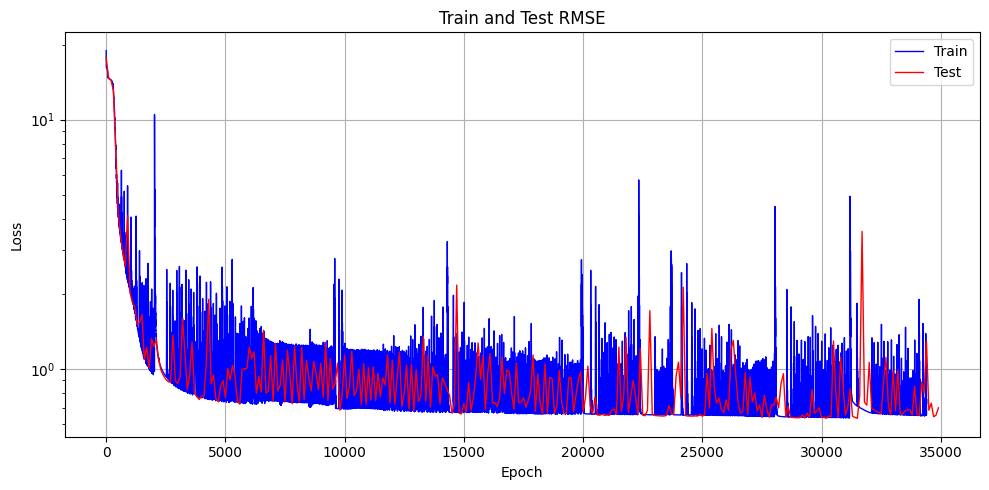

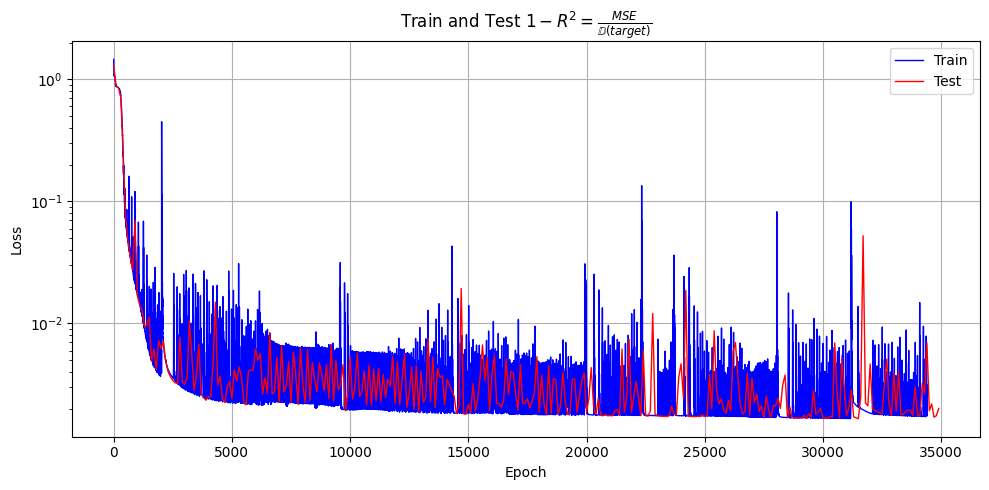

Training interrupted by user.


In [20]:
cnt_epochs = 1_000_000
plot_interval = 50
test_interval = 100
snapshot_interval = 1000
losses_train = []
losses_test = []
grid_test = []

checkpoint_path = f"cache/{session.id}"

# Загружаем последний чекпоинт, если он есть
init_epoch, losses_train, losses_test, grid_test = load_checkpoint(
    model_market, 
    model_option_put, 
    model_option_call, 
    model_forward, 
    optimizer, 
    path=checkpoint_path
)

# Проверка, если модель не была обучена ранее
if init_epoch >= cnt_epochs - 1:
    raise Exception("Already fitted")

tensorboard_dir = f"tensorboard/BlackScholes/{session.id}"
!/bin/mkdir  "{tensorboard_dir}"
!/bin/rm "{tensorboard_dir}"/*
writer = SummaryWriter(log_dir=tensorboard_dir)

# Перезаписываем сохранённые лоссы
for epoch, loss in enumerate(losses_train):
    writer.add_scalar("Loss/train", loss, epoch)
for i, loss in enumerate(losses_test):
    writer.add_scalar("Loss/test", loss, i * test_interval)

print(f"TensorBoard logging to: {tensorboard_dir}")


# Training loop
try:
    for epoch in tqdm(range(init_epoch, cnt_epochs)):
        model_market.train()
        model_option_put.train()
        model_option_call.train()
        model_forward.train()
        
        optimizer.zero_grad()

        loss_train = 0.0
        for market, derivative, price, model_derivative in [
            (markets_option_put, options_put, options_put_price, model_option_put),
            (markets_option_call, options_call, options_call_price, model_option_call),
            (markets_forward, forwards, forwards_price, model_forward)
        ]:
            embedding_market = model_market(market[train_mask])
            embedding_derivative = model_derivative(derivative[train_mask])
            predictions_train = torch.sum(embedding_market * embedding_derivative, dim=1)
            loss_train += criterion(predictions_train, price[train_mask])

        loss_train /= 3.0
        losses_train.append(loss_train.item() ** 0.5)
        writer.add_scalar("Loss/train", losses_train[-1], epoch)

        loss_train.backward()
        optimizer.step()

        # Test evaluation
        if epoch % test_interval == 0 or epoch == cnt_epochs - 1:
            loss_test = 0.0
            model_market.eval()
            for market, derivative, price, model_derivative in [
                (markets_option_put, options_put, options_put_price, model_option_put),
                (markets_option_call, options_call, options_call_price, model_option_call),
                (markets_forward, forwards, forwards_price, model_forward)
            ]:
                model_derivative.eval()
                with torch.no_grad():
                    embedding_market_test = model_market(market[~train_mask])
                    embedding_derivative_test = model_derivative(derivative[~train_mask])
                    predictions_test = torch.sum(embedding_market_test * embedding_derivative_test, dim=1)
                    loss_test += criterion(predictions_test, price[~train_mask])
            grid_test.append(epoch)
            loss_test /= 3.0
            losses_test.append(loss_test.item() ** 0.5)
            writer.add_scalar("Loss/test", losses_test[-1], epoch)

        # saving checkpoint
        if epoch % snapshot_interval == 0 or epoch == cnt_epochs - 1:
            save_checkpoint(epoch, model_market, model_option_put, model_option_call, model_forward, optimizer, losses_train, losses_test, grid_test, checkpoint_path)

        # Plotting
        if epoch % plot_interval == 0 or epoch == cnt_epochs - 1:
            clear_output(wait=True)

            # # Обычный график
            # plt.figure(figsize=(10, 5))
            # plt.plot(losses_train, label="Train", color='blue', linewidth=1)
            # plt.plot(range(0, len(losses_test) * test_interval, test_interval), losses_test, label="Test", color='red', linewidth=1)
            # plt.xlabel("Epoch")
            # plt.ylabel("Loss")
            # plt.title("Train and Test RMSE")
            # plt.grid()
            # plt.legend()
            # plt.tight_layout()
            # plt.show()

            # Логарифмическая шкала
            plt.figure(figsize=(10, 5))
            plt.plot(losses_train, label="Train", color='blue', linewidth=1)
            plt.plot(grid_test, losses_test, label="Test", color='red', linewidth=1)
            plt.yscale('log')
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Train and Test RMSE")
            plt.grid()
            plt.legend()
            plt.tight_layout()
            plt.show()

            # 1 - r2 log
            plt.figure(figsize=(10, 5))
            plt.plot(np.array(losses_train)**2 / 
                     (options_put_price[train_mask].std()**2 + options_call_price[train_mask].std()**2 + forwards_price[train_mask].std()**2) * 3, 
                     label="Train", color='blue', linewidth=1)
            plt.plot(grid_test, np.array(losses_test)**2 / 
                     (options_put_price[~train_mask].std()**2 + options_call_price[~train_mask].std()**2 + forwards_price[~train_mask].std()**2) * 3,
                       label="Test", color='red', linewidth=1)
            plt.yscale('log')
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(r"Train and Test $1-R^2=\frac{MSE}{\mathbb{D}(target)}$")
            plt.grid()
            plt.legend()
            plt.tight_layout()
            plt.show()


except KeyboardInterrupt:
    print("Training interrupted by user.")

finally:
    writer.close()

In [ ]:
raise Exception
session.clear()

# Scores

In [21]:
from sklearn.metrics import mean_absolute_error as mae, root_mean_squared_error as rmse, r2_score as r2

model_market.eval()
with torch.no_grad():
    for name, market, derivative, price, model_derivative in [
            ("Option Put", markets_option_put, options_put, options_put_price, model_option_put),
            ("Option Call", markets_option_call, options_call, options_call_price, model_option_call),
            ("Forward", markets_forward, forwards, forwards_price, model_forward)
        ]:
            model_derivative.eval()

            embedding_market = model_market(market[train_mask])
            embedding_derivative = model_derivative(derivative[train_mask])
            predictions_train = torch.sum(embedding_market * embedding_derivative, dim=1)

            embedding_market_test = model_market(market[~train_mask])
            embedding_derivative_test = model_derivative(derivative[~train_mask])
            predictions_test = torch.sum(embedding_market_test * embedding_derivative_test, dim=1)

            scores = pd.DataFrame({
                "metric": [
                    "RMSE", 
                    "R2", 
                    "MAE"
                ],
                "Train": [
                    rmse(price[train_mask], predictions_train), 
                    r2(price[train_mask], predictions_train), 
                    mae(price[train_mask], predictions_train)
                ],
                "Test": [
                    rmse(price[~train_mask], predictions_test), 
                    r2(price[~train_mask], predictions_test), 
                    mae(price[~train_mask], predictions_test)
                ]
            })
            scores = scores.set_index("metric")
            # scores.to_markdown(f"cache/{session.id}/scores.md")
            # scores.to_pickle(f"saves/{session.id}/scores.pckl")
            print(name)
            display(scores)

Option Put


,Train,Test
metric,,
RMSE,0.739467,0.731394
R2,0.995003,0.995213
MAE,0.544317,0.540005


Option Call


,Train,Test
metric,,
RMSE,0.720951,0.714578
R2,0.996831,0.996935
MAE,0.557391,0.553251


Forward


,Train,Test
metric,,
RMSE,0.510290,0.507397
R2,0.999433,0.999428
MAE,0.398485,0.396849


tensor(10.4829)

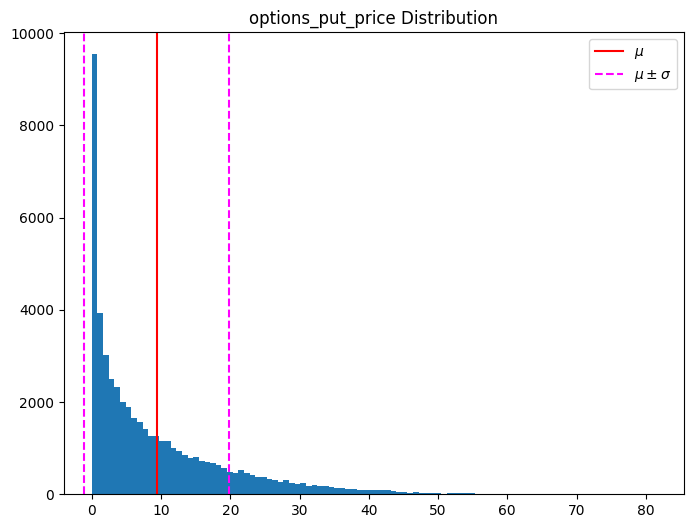

In [22]:
plt.figure(figsize=(8, 6))
plt.title("options_put_price Distribution")
plt.hist(options_put_price, bins=100)
plt.axvline(options_put_price.mean(), color='r', label=r"$\mu$")
plt.axvline(options_put_price.mean() + options_put_price.std(), linestyle="--", color='magenta', label=r"$\mu \pm \sigma$")
plt.axvline(options_put_price.mean() - options_put_price.std(), linestyle="--", color='magenta')
# plt.axvline(np.median(target), linestyle="--", color='r', label="median")
plt.legend()
plt.grid(False)
options_put_price.std()

tensor(12.8271)

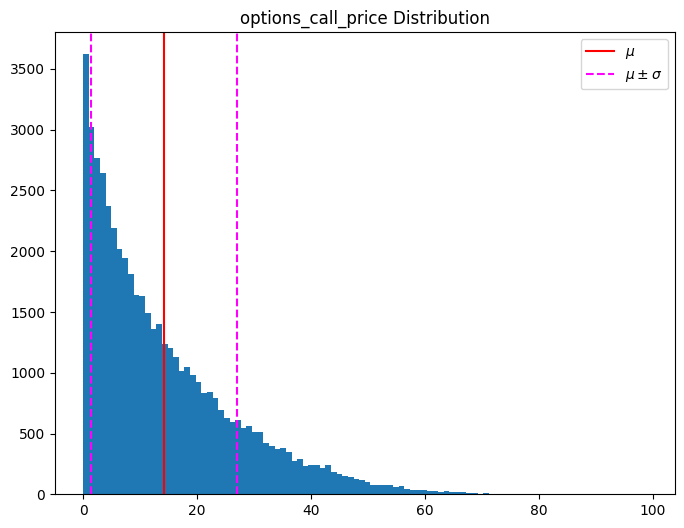

In [23]:
plt.figure(figsize=(8, 6))
plt.title("options_call_price Distribution")
plt.hist(options_call_price, bins=100)
plt.axvline(options_call_price.mean(), color='r', label=r"$\mu$")
plt.axvline(options_call_price.mean() + options_call_price.std(), linestyle="--", color='magenta', label=r"$\mu \pm \sigma$")
plt.axvline(options_call_price.mean() - options_call_price.std(), linestyle="--", color='magenta')
# plt.axvline(np.median(target), linestyle="--", color='r', label="median")
plt.legend()
plt.grid(False)
options_call_price.std()

tensor(21.3903)

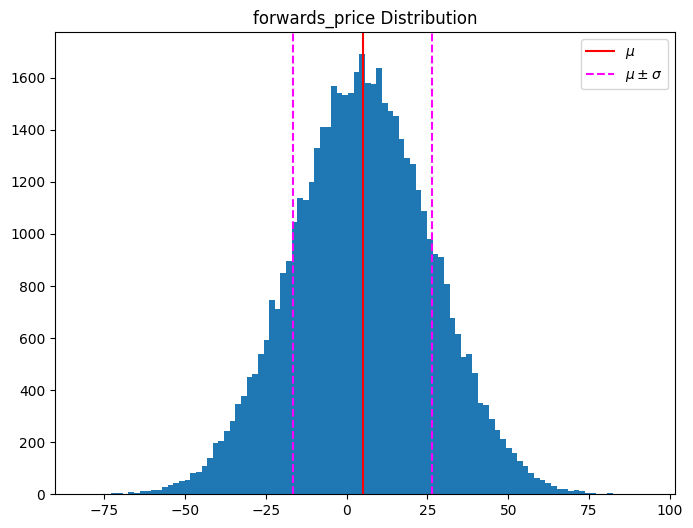

In [24]:
plt.figure(figsize=(8, 6))
plt.title("forwards_price Distribution")
plt.hist(forwards_price, bins=100)
plt.axvline(forwards_price.mean(), color='r', label=r"$\mu$")
plt.axvline(forwards_price.mean() + forwards_price.std(), linestyle="--", color='magenta', label=r"$\mu \pm \sigma$")
plt.axvline(forwards_price.mean() - forwards_price.std(), linestyle="--", color='magenta')
# plt.axvline(np.median(target), linestyle="--", color='r', label="median")
plt.legend()
plt.grid(False)
forwards_price.std()

# Linearization Analysis
1. Обрезаем SVD для market
2. Смотрим на плоскость в которой он лежит
3. Проецируем все деривативы на нее (цена не чувствует ортогональное дополнение к этой плоскости)
4. ...

Можно еще подумать над тем, что произошло в данном случае с репликацией пэйоффа --- интеграл по плотности разложился в ряд по базисным функциям (мб можно их построить), еще можно поисследовать как сходится regression based MC для таких функций

In [ ]:
CNT = 10_000

In [ ]:
init_market = StateHolder(
        np.array([
                100.,  # asset0,
                0.2,  # sigma
                0.05  # discount rate
            ]),
        Markets.BlackScholes
    )
    
init_option_put = StateHolder(
    np.array([
        100.,  # strike
        1.  # maturity
    ]),
    Derivatives.OptionPut
)
init_option_call = StateHolder(
    np.array([
        100.,  # strike
        1.  # maturity
    ]),
    Derivatives.OptionCall
)
init_forward = StateHolder(
    np.array([
        100.,  # strike
        1.  # maturity
    ]),
    Derivatives.Forward
)

In [29]:
from src.Pricing import price
price(init_market, init_option_call) - price(init_market, init_option_put), price(init_market, init_forward)

(4.877057549928601, 4.877057549928594)

In [ ]:
markets = init_market.generate_states_arround(CNT, sigmas = init_market.get_state() / 10.)
markets = torch.tensor(np.array(list(map(lambda x: x.get_state(), markets)))).float().to(device)

tensor([[8.8148e+01, 1.6128e-01, 5.4224e-02],
        [8.8062e+01, 1.7536e-01, 4.8055e-02],
        [1.0399e+02, 2.0868e-01, 4.8630e-02],
        ...,
        [9.6173e+01, 1.7732e-01, 4.1861e-02],
        [9.3210e+01, 1.6920e-01, 5.1208e-02],
        [8.9878e+01, 2.1993e-01, 5.9782e-02]])

In [58]:
with torch.no_grad():
    model_market.eval()
    market_embeddings = model_market(markets)
market_embeddings = market_embeddings.numpy()

In [80]:
u, s, vh = np.linalg.svd(market_embeddings.T, full_matrices=False)

In [73]:
derivatives = torch.tensor(np.array(list(map(lambda x: x.get_state(), 
                                             init_option_put.generate_states_arround(CNT, sigmas = [20., 0.]))))[:, 0].reshape(-1, 1)).float().to(device)

In [85]:
with torch.no_grad():
    model_option_put.eval()
    put_embeddings = model_option_put(derivatives).numpy()

    model_option_call.eval()
    call_embeddings = model_option_call(derivatives).numpy()

    model_forward.eval()
    forwards_embeddings = model_forward(derivatives).numpy()

In [ ]:
def approximate_subspace_svd(X: np.ndarray, k: int):
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    basis = Vt[:k]
    return basis

In [87]:
flag_of_markets_space = [
    approximate_subspace_svd(market_embeddings, k) 
    for k in range(1, market_embeddings.shape[1] + 1)
]

In [95]:
diff_vecs = put_embeddings + forwards_embeddings - call_embeddings

In [125]:
np.linalg.norm(((diff_vecs @ market_embeddings.T))) / np.sqrt(2) / CNT

0.06893026748877087

In [124]:
((diff_vecs @ market_embeddings.T) ** 2).mean()

0.052077994

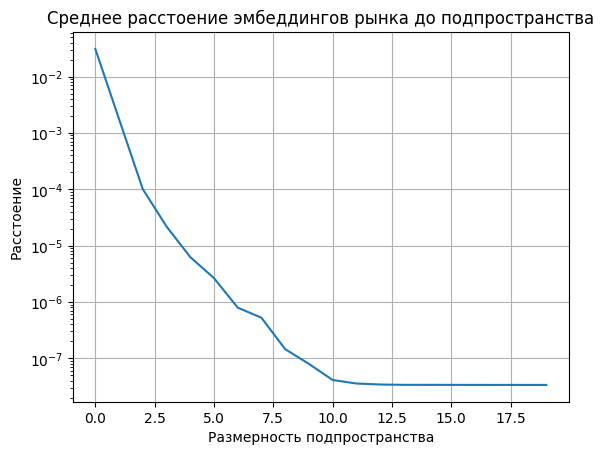

In [127]:
error = []
for basis in flag_of_markets_space:
    error.append(
        np.linalg.norm((market_embeddings - market_embeddings @ basis.T @ basis), axis=1).mean()
    )
plt.semilogy(error)
plt.title("Среднее расстоение эмбеддингов рынка до подпространства")
plt.xlabel("Размерность подпространства")
plt.ylabel("Расстоение")
plt.grid()
plt.show()

(50000,)

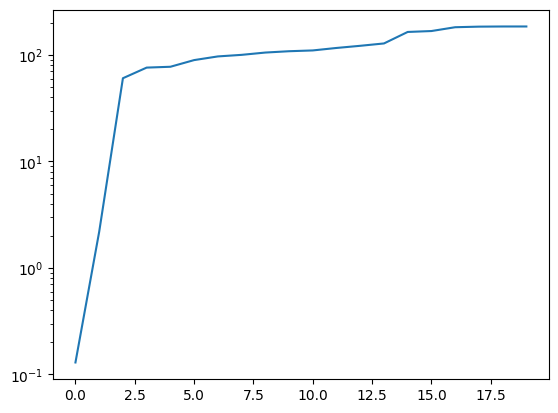

In [126]:
error = []
for basis in flag_of_markets_space:
    error.append(
        np.linalg.norm(diff_vecs @ basis.T, axis=1).mean()
    )
plt.semilogy(error);
np.linalg.norm(diff_vecs @ basis.T, axis=1).shape